# Курсовой проект для курса "Python для Data Science"

Цель - предсказать цены на недвижимость (квартиры).

**Описание датасета**

Статистические данные о ряде квартир.

* **DistrictId** - район
* **Rooms** - комнаты
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - этажность дома
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные со здравоохранением
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов
* **Price** - стоимость

In [103]:
import numpy as np
import pandas as pd
import pickle
from statistics import mode, median
import random
from datetime import datetime

from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d.axes3d import Axes3D

from sklearn.preprocessing import StandardScaler, RobustScaler

# Кластеризация
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

from sklearn.neighbors import KNeighborsClassifier

# Понижения размерности
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse

# Модели
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

**Функции**

In [104]:
def reduce_mem_usage(data):
    ''' Перебирает все столбцы датасета и меняет тип данных
        для уменьшения используемой памяти''' 
    start_mem = data.memory_usage().sum() / 1024**2
    print('Объем используемой памяти составляет {:.2f} MB'.format(start_mem))
    
    for col in data.columns:
        col_type = data[col].dtype
        
        if col_type != object:
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    data[col] = data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data[col] = data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    data[col] = data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)
        else:
            data[col] = data[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Используемая память после оптимизации: {:.2f} MB'.format(end_mem))
    print('Уменьшилась на {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return data

def unique_values_in_column(data,feature):
    ''' Выводит уникальные значения'''
    unique_val=pd.Series(data.loc[:,feature].unique())
    print(unique_val)
    
def data_gaps(data,feature):
    ''' Замена пропусков на медиану'''
    data[[feature]] = data[[feature]].fillna(data[[feature]].median())

def categorical_variables(data,feature,new_column):
    ''' Кодирование категориальных переменных'''
    data[feature] = data[feature].astype('category')
    data[new_column] = data[feature].cat.codes
    print(data[[feature, new_column]])

def emission_outliers(data,feature):
    ''' Обработка выбросов. Наблюдения, значения которых больше 97,5% квантиля и которые меньше 2,5% квантиля будем считать выбросами и заменять на медиану.'''
    print(data[feature].describe())
    max_value = np.quantile(data[feature], q=0.975)
    min_value = np.quantile(data[feature], q=0.025)
    condition = (data[feature] > max_value) | (data[feature] < min_value)
    data.loc[condition, feature] = data[feature].median()
    print(data[feature].describe())
    
def change_to_median(data,feature,log_operator,value):
    ''' Замена данных на медиану'''
    if log_operator == '>':
        data.loc[data[feature] > value, feature] = data[feature].median()
    elif log_operator == '<':
        data.loc[data[feature] < value, feature] = data[feature].median()
    elif log_operator == '=':
        data.loc[data[feature] == value, feature] = data[feature].median()
    else:
        print('Добавить новый оператор в функцию')

def drop_outliers(data,feature):
    ''' Удаление выбросов'''
    max_value = np.quantile(data[feature], q=0.975)
    min_value = np.quantile(data[feature], q=0.025)
    
    size_before = data[column].size
    data.drop(data[(data[column]<min_value)|(data[column]>max_value)].index, axis=0, inplace=True)    
    size_after = data[column].size
    
    lost_percentage = (size_before - size_after) * 100 / size_before 
    print('Потеряно {lost_percentage}% данных.')
    
def emission_visual(data,feature,y_line):
    ''' Визуализация + средняя/медиана/мода'''
    target_mean = round(data[feature].mean(), 2)
    target_median = data[feature].median()
    target_mode = data[feature].mode()[0]

    plt.figure(figsize = (16, 8))

    sns.distplot(data[feature], bins=50)

    y = np.linspace(0, y_line, 10)
    plt.plot([target_mean] * 10, y, label='mean',  linewidth=2)
    plt.plot([target_median] * 10, y, label='median',  linewidth=2)
    plt.plot([target_mode] * 10, y, label='mode', linewidth=2)

    plt.title(f'Distribution of {feature}')
    plt.legend()
    plt.show()
    print(f'Mean {target_mean}')
    print(f'Median {target_median}')
    print(f'Mode {target_mode}')
    
def draw_scatter(data, column_x, column_y):
    ''' scatter-график по двум признакам'''
    plt.scatter(data[column_x], data[column_y])
    plt.xlabel(column_x)
    plt.ylabel(column_y)
    plt.show()  

def joint_diagram(data, column_x, column_y):
    ''' joint-диаграмма по двум признакам'''
    grid = sns.jointplot(data[column_x], data[column_y], kind='reg')
    grid.fig.set_figwidth(8)
    grid.fig.set_figheight(8)
    plt.show()
    
def evaluate_preds(true_values, pred_values, save=False):
    ''' Оценка качества модели и график preds vs true'''
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

In [106]:
DATASET_PATH = 'train.csv'
PREPARED_DATASET_PATH = 'test.csv'

MODEL_FILE_PATH = './models/model.pkl'

In [107]:
df = pd.read_csv(DATASET_PATH, sep=',')
df = reduce_mem_usage(df)
df.head()

Объем используемой памяти составляет 1.53 MB
Используемая память после оптимизации: 0.49 MB
Уменьшилась на 68.1%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.937500
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.437500
2,4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.906250
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.234375
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531250


In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

In [109]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315712,37.199596,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214139.218750
std,4859.01902,43.587592,0.839523,21.058718,86.241112,28.561113,5.241148,6.776192,2.005003e+05,0.119026,17.532614,4006.799803,23.831875,1021.518982,1.493601,4.806341,92872.304688
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


# Обработка пропусков

In [110]:
df.isnull().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [111]:
data_gaps(df,'LifeSquare')

Признак Healthcare_1 будет не информативен, если мы его тоже заменим на медиану, поэтому полностью удаляем данный признак.

In [112]:
df.drop('Healthcare_1', axis=1,inplace=True)

In [113]:
df.isnull().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

# Обработка категориальных переменных

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     10000 non-null  float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Helthcare_2    10000 non-null  int8    
 16  Shops_1        10000 non-null  int8    
 17  Shops_2        10000 non-null  c

In [115]:
unique_values_in_column(df,'Ecology_2')

0    B
1    A
dtype: category
Categories (2, object): ['A', 'B']


In [116]:
set(df.loc[:,'Ecology_2'].unique()) == set(df.loc[:,'Shops_2'].unique()) == set(df.loc[:,'Ecology_3'].unique())

True

In [117]:
obj_df = df.select_dtypes(include=['object']).copy()
obj_df.head()

""
0
1
2
3
4


In [118]:
obj_df[obj_df.isnull().any(axis=1)]

""


In [119]:
categorical_variables(df,'Ecology_2','Ecology_2_coding')

     Ecology_2  Ecology_2_coding
0            B                 1
1            B                 1
2            B                 1
3            B                 1
4            B                 1
...        ...               ...
9995         B                 1
9996         B                 1
9997         B                 1
9998         B                 1
9999         B                 1

[10000 rows x 2 columns]


In [120]:
categorical_variables(df,'Ecology_3','Ecology_3_coding')

     Ecology_3  Ecology_3_coding
0            B                 1
1            B                 1
2            B                 1
3            B                 1
4            B                 1
...        ...               ...
9995         B                 1
9996         B                 1
9997         B                 1
9998         A                 0
9999         B                 1

[10000 rows x 2 columns]


In [121]:
categorical_variables(df,'Shops_2','Shops_2_coding')

     Shops_2  Shops_2_coding
0          B               1
1          B               1
2          B               1
3          B               1
4          B               1
...      ...             ...
9995       B               1
9996       A               0
9997       A               0
9998       B               1
9999       B               1

[10000 rows x 2 columns]


In [122]:
df.head(4)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_coding,Ecology_3_coding,Shops_2_coding
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,...,33,7976,5,0,11,B,184966.937500,1,1,1
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,...,46,10309,1,1,16,B,300009.437500,1,1,1
2,4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,...,34,7759,0,1,3,B,220925.906250,1,1,1
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,...,23,5735,3,0,5,B,175616.234375,1,1,1


# Обработка выбросов

In [123]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Price,Ecology_2_coding,Ecology_3_coding,Shops_2_coding
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315712,36.266048,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1.319500,4.231300,214139.218750,0.990300,0.972500,0.917500
std,4859.01902,43.587592,0.839523,21.058718,76.609917,28.561113,5.241148,6.776192,2.005003e+05,0.119026,17.532614,4006.799803,23.831875,1.493601,4.806341,92872.304688,0.098015,0.163543,0.275139
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,59174.777344,0.000000,0.000000,0.000000
25%,4169.50000,20.000000,1.000000,41.774879,25.527400,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,0.000000,1.000000,153872.628906,1.000000,1.000000,1.000000
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,1.000000,3.000000,192269.648438,1.000000,1.000000,1.000000
75%,12592.50000,75.000000,2.000000,65.900627,41.427234,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,2.000000,6.000000,249135.460938,1.000000,1.000000,1.000000
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,6.000000,23.000000,633233.437500,1.000000,1.000000,1.000000


**Распределение целевой переменной**

In [124]:
df['Price'].describe()

count     10000.000000
mean     214139.218750
std       92872.304688
min       59174.777344
25%      153872.628906
50%      192269.648438
75%      249135.460938
max      633233.437500
Name: Price, dtype: float64

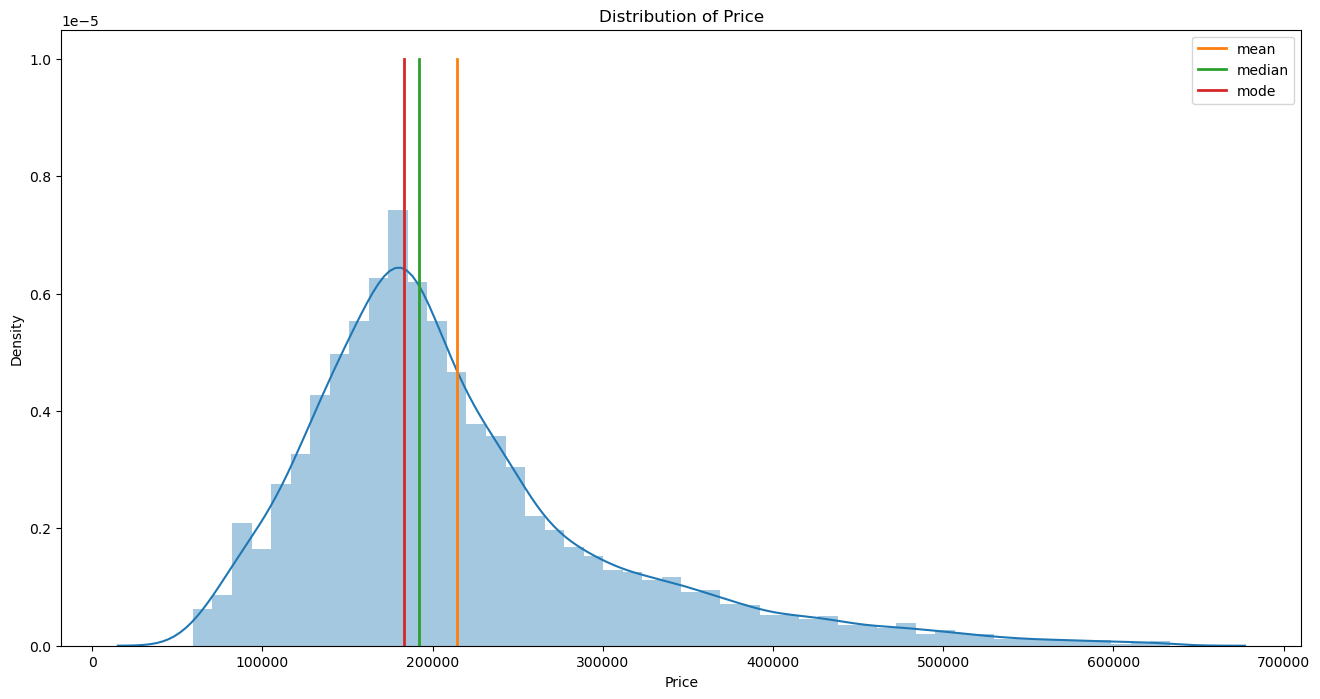

Mean 214139.22
Median 192269.65625
Mode 182938.078125


In [125]:
emission_visual(df,'Price',0.00001)

С целевой переменной все ок.

# Анализ признаков

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Id                10000 non-null  int16   
 1   DistrictId        10000 non-null  int16   
 2   Rooms             10000 non-null  float32 
 3   Square            10000 non-null  float32 
 4   LifeSquare        10000 non-null  float32 
 5   KitchenSquare     10000 non-null  float32 
 6   Floor             10000 non-null  int8    
 7   HouseFloor        10000 non-null  float32 
 8   HouseYear         10000 non-null  int32   
 9   Ecology_1         10000 non-null  float32 
 10  Ecology_2         10000 non-null  category
 11  Ecology_3         10000 non-null  category
 12  Social_1          10000 non-null  int8    
 13  Social_2          10000 non-null  int16   
 14  Social_3          10000 non-null  int16   
 15  Helthcare_2       10000 non-null  int8    
 16  Shops_1           10000

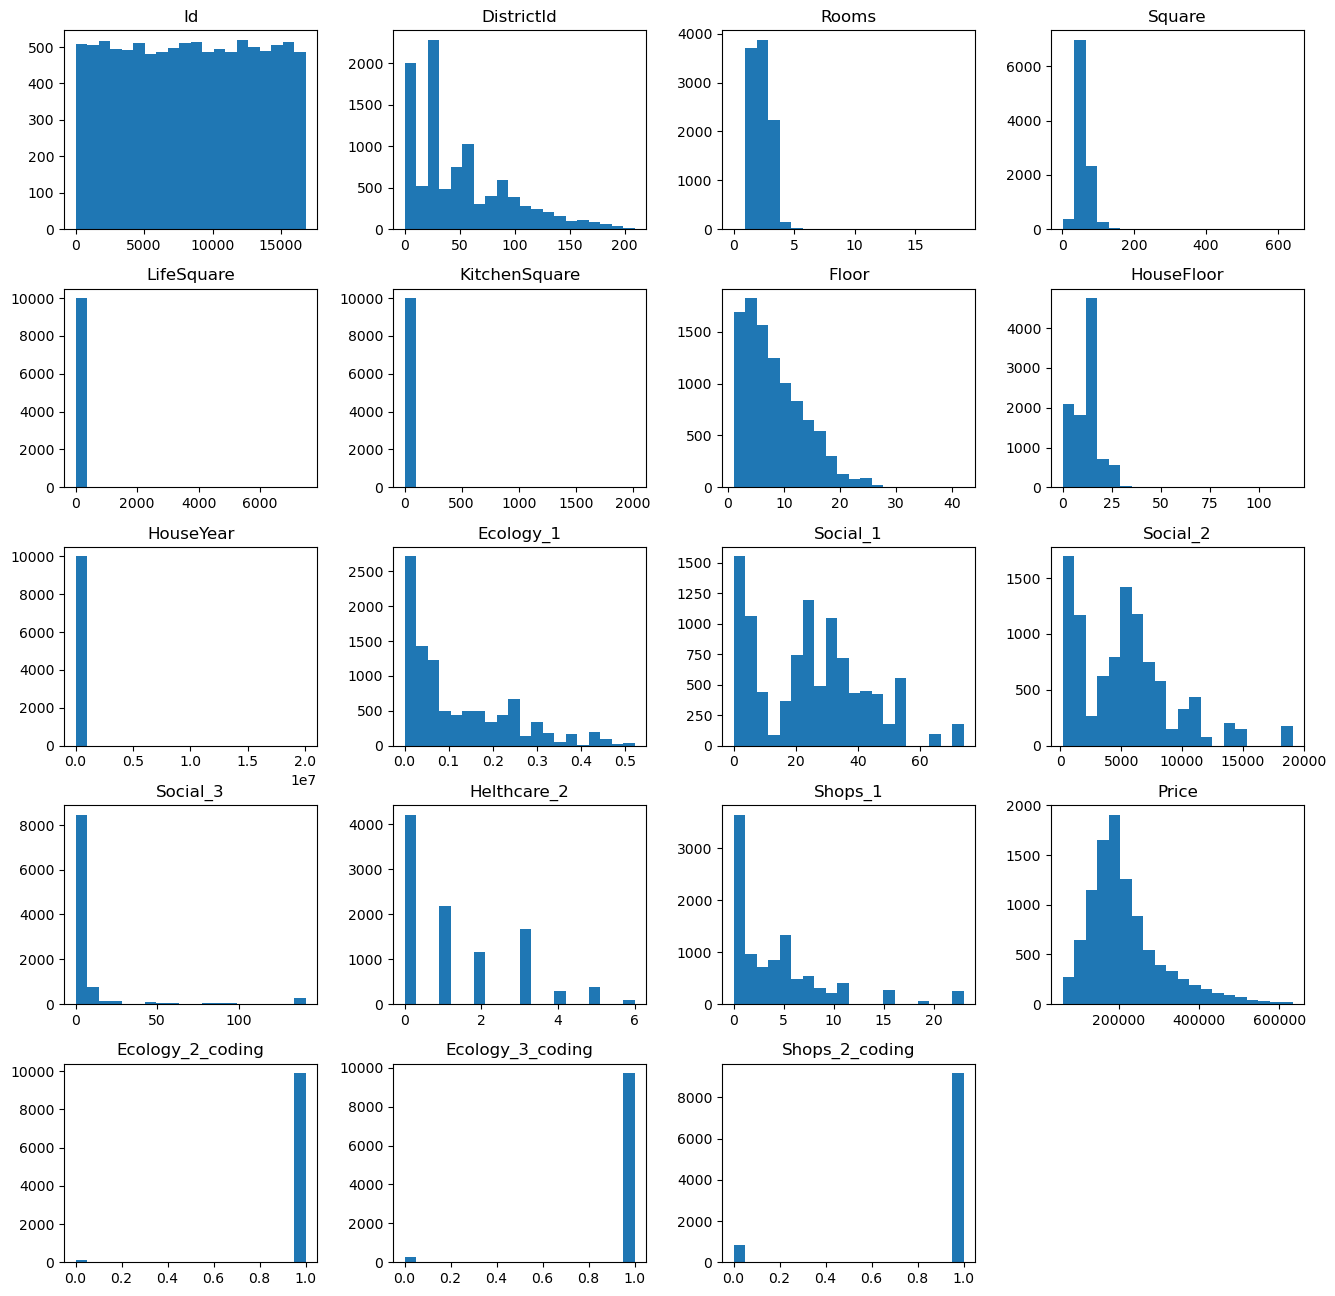

In [127]:
df.hist(figsize=(16,16), bins=20, grid=False);

**Rooms**

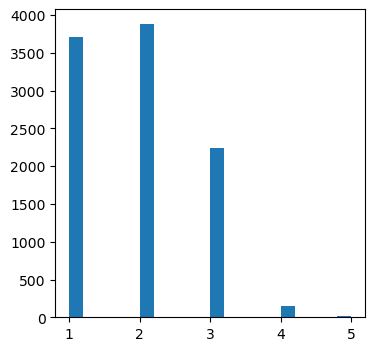

In [133]:
df.loc[df['Rooms'] < 6, 'Rooms'].\
    hist(figsize=(4,4), bins=20, grid=False);

In [134]:
df[df['Rooms'] > 6]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_coding,Ecology_3_coding,Shops_2_coding


In [135]:
change_to_median(df,'Rooms','>',6)

In [136]:
df[df['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_coding,Ecology_3_coding,Shops_2_coding


In [137]:
df.loc[df['Rooms'] == 0, 'Rooms'] = 1

**LifeSquare**

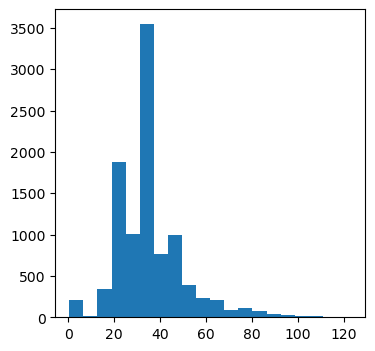

In [138]:
df.loc[df['LifeSquare'] < 125, 'LifeSquare'].\
    hist(figsize=(4,4), bins=20, grid=False);

In [139]:
emission_outliers(df,'LifeSquare')

count    10000.000000
mean        36.266048
std         76.609917
min          0.370619
25%         25.527400
50%         32.781261
75%         41.427234
max       7480.592285
Name: LifeSquare, dtype: float64
count    10000.000000
mean        34.534420
std         11.451111
min         15.146290
25%         27.982506
50%         32.781261
75%         39.424684
max         78.384628
Name: LifeSquare, dtype: float64


**KitchenSquare**

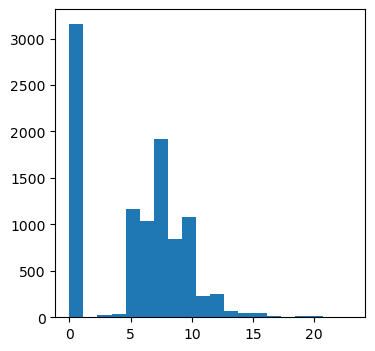

In [140]:
df.loc[df['KitchenSquare'] < 25, 'KitchenSquare'].\
    hist(figsize=(4,4), bins=20, grid=False);

In [141]:
df['KitchenSquare'].describe()

count    10000.000000
mean         6.273300
std         28.561113
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64

In [142]:
emission_outliers(df,'KitchenSquare')

count    10000.000000
mean         6.273300
std         28.561113
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64
count    10000.000000
mean         5.536700
std          3.670607
min          0.000000
25%          1.000000
50%          6.000000
75%          8.000000
max         13.000000
Name: KitchenSquare, dtype: float64


Заменю данные, которые меньше 4

In [143]:
df.loc[df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

**Square**

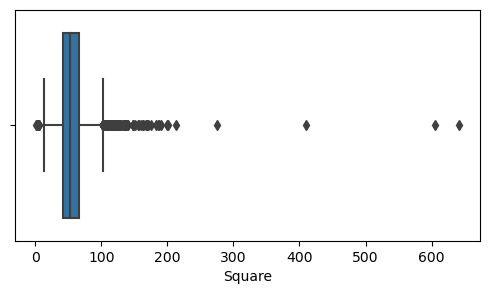

In [144]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['Square'], whis=1.5)

plt.xlabel('Square')
plt.show()

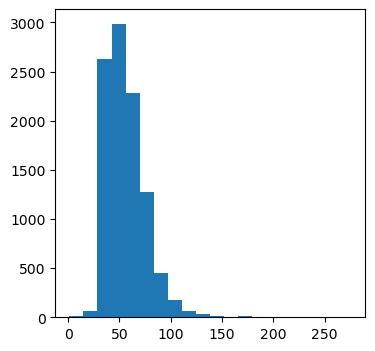

In [145]:
df.loc[df['Square'] < 300, 'Square'].\
    hist(figsize=(4,4), bins=20, grid=False);

In [146]:
change_to_median(df,'Square','>',200)

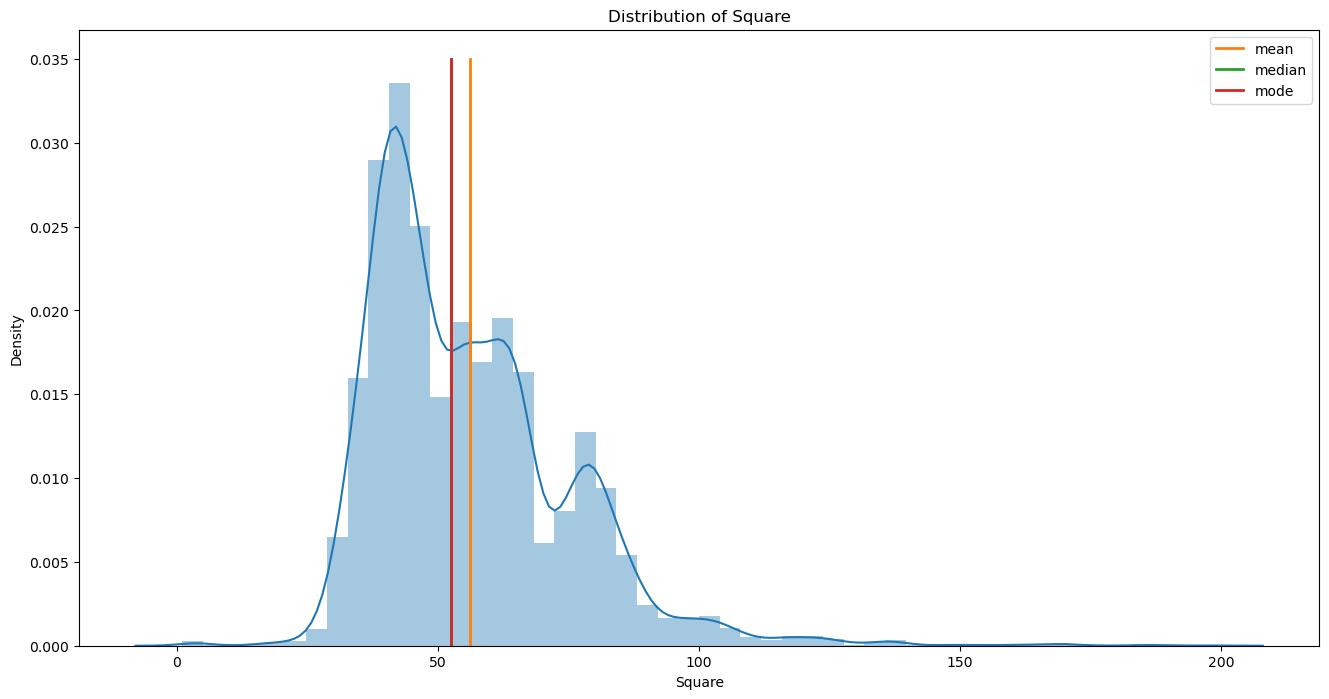

Mean 56.11
Median 52.513038635253906
Mode 52.513309478759766


In [147]:
emission_visual(df,'Square',0.035)

In [148]:
df['Square'].describe()

count    10000.000000
mean        56.112823
std         18.903887
min          1.136859
25%         41.774879
50%         52.513039
75%         65.879387
max        198.930176
Name: Square, dtype: float64

Заменю все значения меньше 20 на медиану

In [149]:
change_to_median(df,'Square','<',20)

In [150]:
df['Square'].describe()

count    10000.000000
mean        56.203056
std         18.780823
min         20.213127
25%         41.811910
50%         52.513174
75%         65.879387
max        198.930176
Name: Square, dtype: float64

**HouseFloor, Floor**

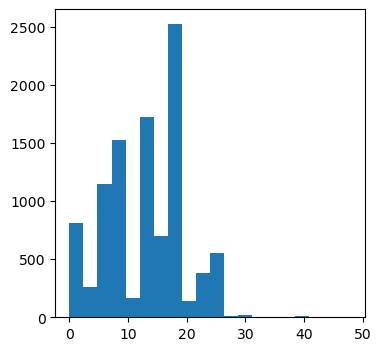

In [151]:
df.loc[df['HouseFloor'] < 87, 'HouseFloor'].\
    hist(figsize=(4,4), bins=20, grid=False);

В России самое высокое здание имеет 87 этажей, заменю данные, которые больше 87, на медиану.

In [152]:
df[df['HouseFloor'] > 87]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_coding,Ecology_3_coding,Shops_2_coding
6131,10806,5,1.0,51.944588,48.709602,3.0,6,99.0,1977,0.150818,...,16,3433,4,4,5,B,296127.12500,1,1,1
8599,9300,74,2.0,71.747871,74.579811,9.0,5,99.0,1977,0.075779,...,6,1437,3,0,2,B,243329.90625,1,1,1
8854,78,30,2.0,65.773750,66.811790,3.0,8,117.0,1977,0.000078,...,22,6398,141,3,23,B,207248.37500,1,1,1


In [153]:
change_to_median(df,'HouseFloor','>',87)

In [154]:
df['HouseFloor'].sort_values().unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 36., 37., 38., 39., 40., 44.,
       45., 47., 48.], dtype=float32)

In [155]:
df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int8)

In [156]:
(df['Floor'] > df['HouseFloor']).sum()

1825

In [157]:
change_to_median(df,'HouseFloor','=',0)

In [158]:
floor_outliers = df.loc[df['Floor'] > df['HouseFloor']].index
floor_outliers

Int64Index([   7,   14,   16,   21,   26,   35,   39,   44,   51,   67,
            ...
            9959, 9962, 9971, 9973, 9975, 9984, 9985, 9989, 9991, 9995],
           dtype='int64', length=1610)

In [159]:
df.loc[floor_outliers, 'Floor'] = df.loc[floor_outliers, 'HouseFloor']\
                                    .apply(lambda x: random.randint(1, x))

**HouseYear**

In [160]:
df[df['HouseYear'] > 2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_coding,Ecology_3_coding,Shops_2_coding
1497,10814,109,1.0,37.265072,20.239714,9.0,9,12.0,20052011,0.136330,...,30,6141,10,3,6,B,254084.531250,1,1,1
4189,11607,147,2.0,44.791836,28.360394,5.0,4,9.0,4968,0.319809,...,25,4756,16,5,8,B,243028.609375,1,1,1


Данные явно ошибочные, заменяю на медиану.

In [161]:
change_to_median(df,'HouseYear','>',2020)

**SquarePrice**

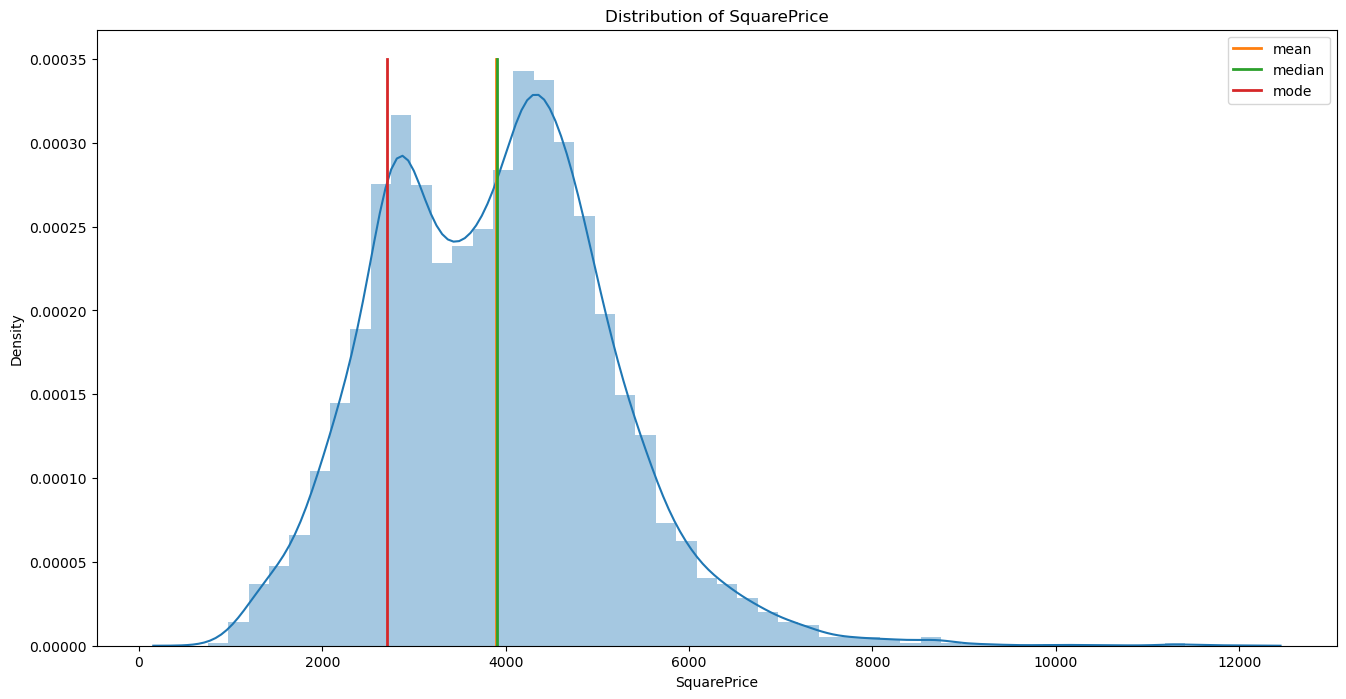

Mean 3890.51
Median 3905.42724609375
Mode 2710.159423828125


In [162]:
df['SquarePrice'] = df['Price']/df['Square']
emission_visual(df,'SquarePrice',0.00035)

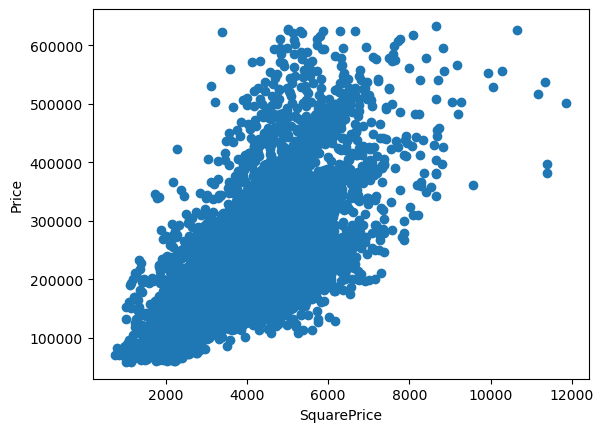

In [163]:
draw_scatter(df,'SquarePrice','Price')

In [164]:
df['SquarePrice'].describe()

count    10000.000000
mean      3890.513672
std       1252.814941
min        752.588684
25%       2915.961670
50%       3905.427368
75%       4689.951172
max      11854.653320
Name: SquarePrice, dtype: float64

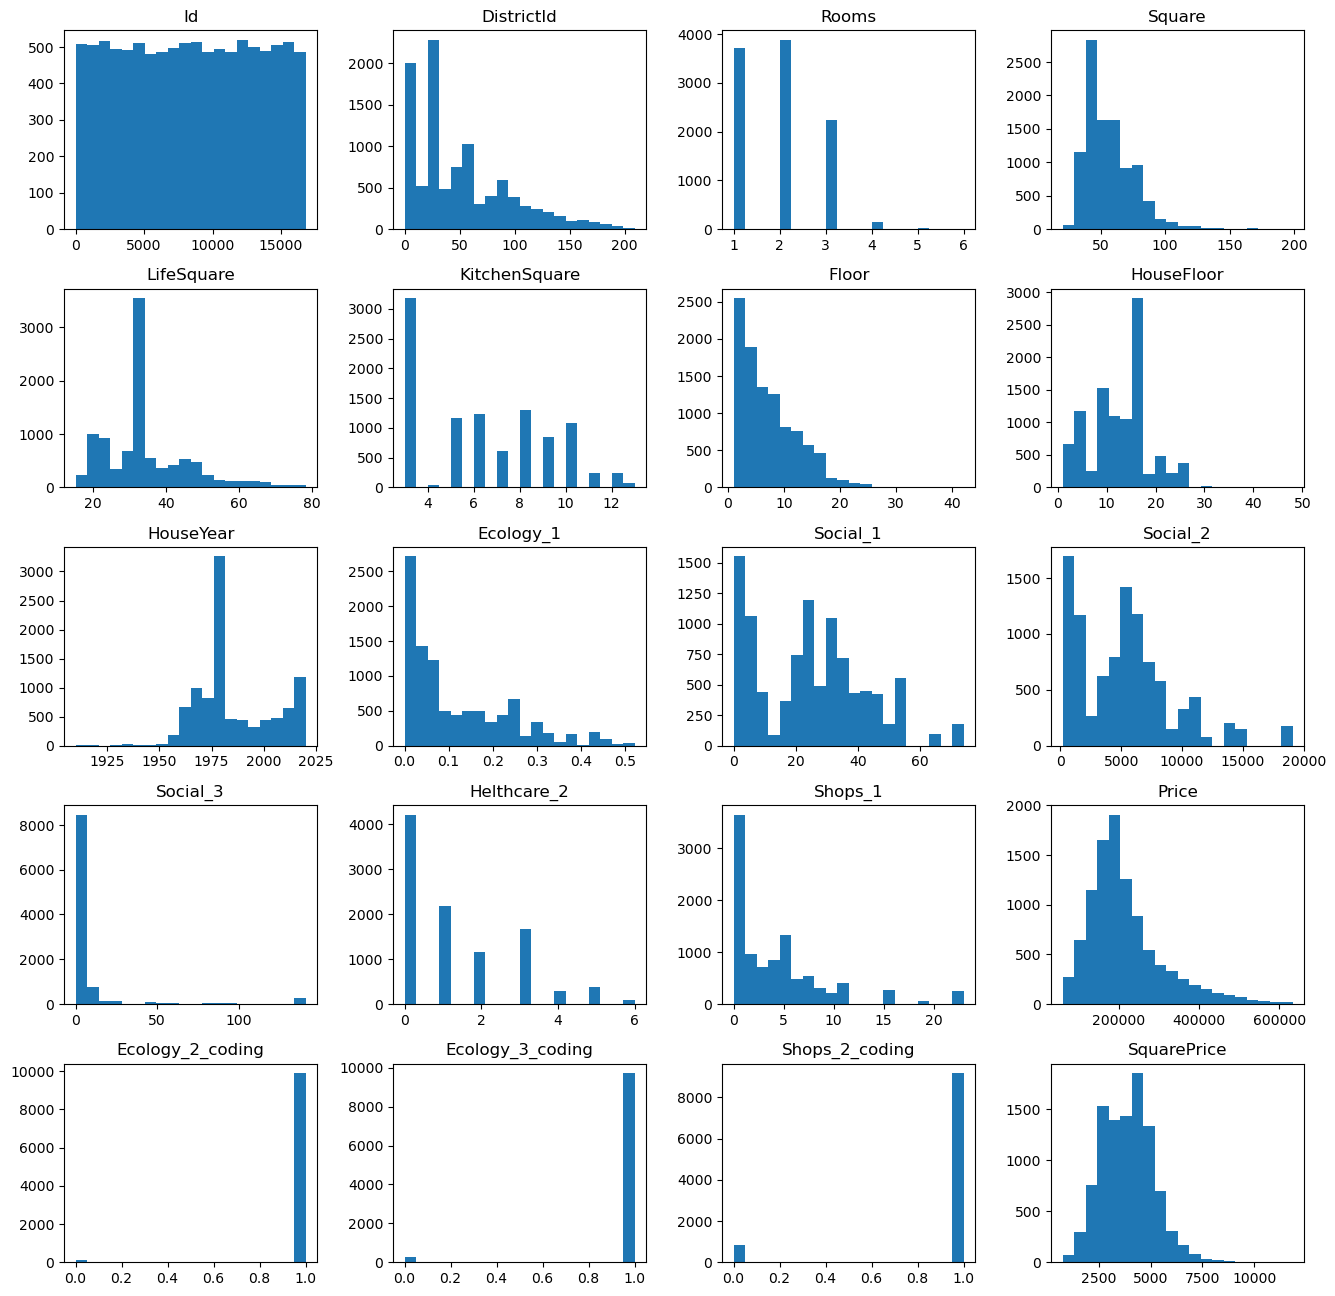

In [165]:
df.hist(figsize=(16,16), bins=20, grid=False);

In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Id                10000 non-null  int16   
 1   DistrictId        10000 non-null  int16   
 2   Rooms             10000 non-null  float32 
 3   Square            10000 non-null  float32 
 4   LifeSquare        10000 non-null  float32 
 5   KitchenSquare     10000 non-null  float32 
 6   Floor             10000 non-null  int64   
 7   HouseFloor        10000 non-null  float32 
 8   HouseYear         10000 non-null  int32   
 9   Ecology_1         10000 non-null  float32 
 10  Ecology_2         10000 non-null  category
 11  Ecology_3         10000 non-null  category
 12  Social_1          10000 non-null  int8    
 13  Social_2          10000 non-null  int16   
 14  Social_3          10000 non-null  int16   
 15  Helthcare_2       10000 non-null  int8    
 16  Shops_1           10000

# Разбиваем на train / valid

In [167]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 
                 'HouseYear', 'Ecology_1', 'Ecology_2_coding', 'Ecology_3_coding', 'Social_1', 
                 'Social_2', 'Social_3', 'Helthcare_2','Shops_1', 'Shops_2_coding']

target_name = 'Price'

In [181]:
X = df[feature_names]
y = df[target_name]
X_final = pd.read_csv(PREPARED_DATASET_PATH, sep=',')

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [182]:
categorical_variables(X_final,'Ecology_2','Ecology_2_coding')
categorical_variables(X_final,'Ecology_3','Ecology_3_coding')
categorical_variables(X_final,'Shops_2','Shops_2_coding')

     Ecology_2  Ecology_2_coding
0            B                 1
1            B                 1
2            B                 1
3            B                 1
4            B                 1
...        ...               ...
4995         B                 1
4996         B                 1
4997         B                 1
4998         B                 1
4999         B                 1

[5000 rows x 2 columns]
     Ecology_3  Ecology_3_coding
0            B                 1
1            B                 1
2            B                 1
3            B                 1
4            B                 1
...        ...               ...
4995         B                 1
4996         B                 1
4997         B                 1
4998         B                 1
4999         B                 1

[5000 rows x 2 columns]
     Shops_2  Shops_2_coding
0          B               1
1          B               1
2          B               1
3          B               1
4          A 

In [184]:
# Rooms
X_final.loc[X_final['Rooms'] == 0, 'Rooms'] = 1
X_final.loc[X_final['Rooms'] >= 6, 'Rooms'] = X_final['Rooms'].median()

In [185]:
# KitchenSquare
condition = (X_final['KitchenSquare'].isna())\
            | (X_final['KitchenSquare'] > X_final['KitchenSquare'].quantile(.975))

X_final.loc[condition, 'KitchenSquare'] = X_final['KitchenSquare'].median()

X_final.loc[X_final['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [186]:
# HouseFloor, Floor
X_final.loc[X_final['HouseFloor'] == 0, 'HouseFloor'] = X_final['HouseFloor'].median()

floor_outliers = X_final.loc[X_final['Floor'] > X_final['HouseFloor']].index
X_final.loc[floor_outliers, 'Floor'] = X_final.loc[floor_outliers, 'HouseFloor']\
                            .apply(lambda x: random.randint(1, x))

In [187]:
# HouseYear
current_year = datetime.now().year

X_final.loc[X_final['HouseYear'] > current_year, 'HouseYear']  = current_year

In [214]:
# Healthcare_1
if 'Healthcare_1' in X_final.columns:
    X_final.drop('Healthcare_1', axis=1, inplace=True)

In [218]:
#LifeSquare
data_gaps(X_final,'LifeSquare')
emission_outliers(X_final,'LifeSquare')

count    5000.000000
mean       35.485549
std        15.915345
min         0.333490
25%        25.850152
50%        32.925087
75%        41.769526
max       303.071094
Name: LifeSquare, dtype: float64
count    5000.000000
mean       34.688864
std        11.424932
min        14.525566
25%        28.166227
50%        32.925087
75%        39.660613
max        77.532039
Name: LifeSquare, dtype: float64


### Linear Regression

R2:	0.525
RMSE:	64046.501
MSE:	4101954306.238


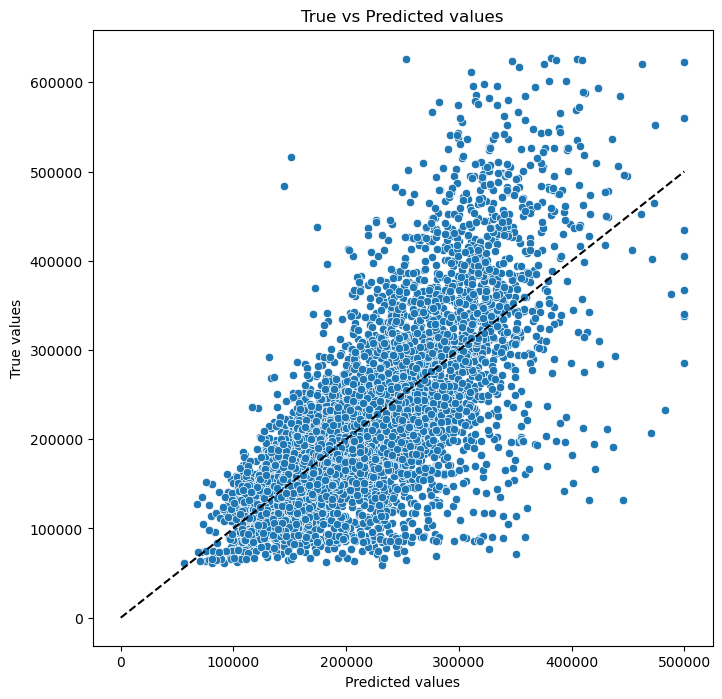

In [190]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_train_preds = lr_model.predict(X_train)

y_train_preds = np.clip(y_train_preds, a_min=10000, a_max=500000)

evaluate_preds(y_train, y_train_preds)

R2:	0.496
RMSE:	65839.268
MSE:	4334809238.504


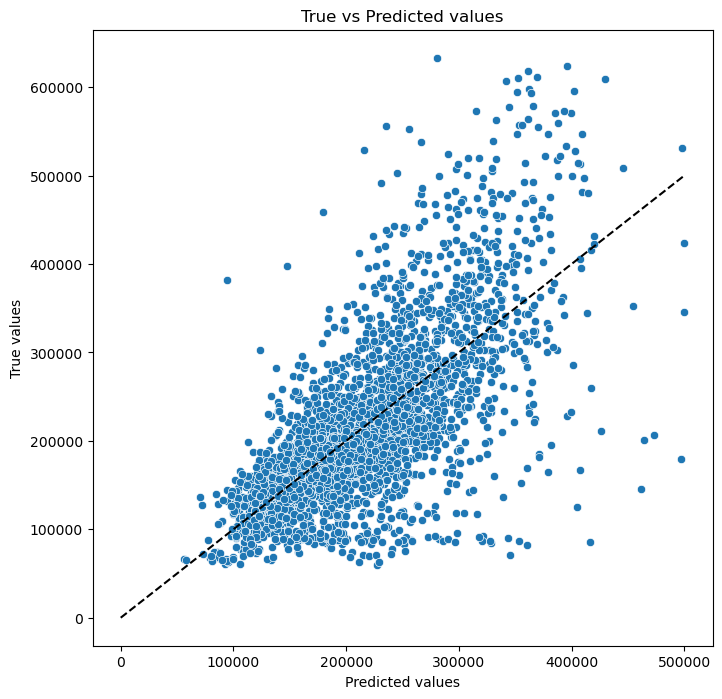

In [191]:
y_valid_preds = lr_model.predict(X_valid)

y_valid_preds = np.clip(y_valid_preds, a_min=10000, a_max=500000)

evaluate_preds(y_valid, y_valid_preds)

### Random Forest

R2:	0.806
RMSE:	40928.435
MSE:	1675136809.99


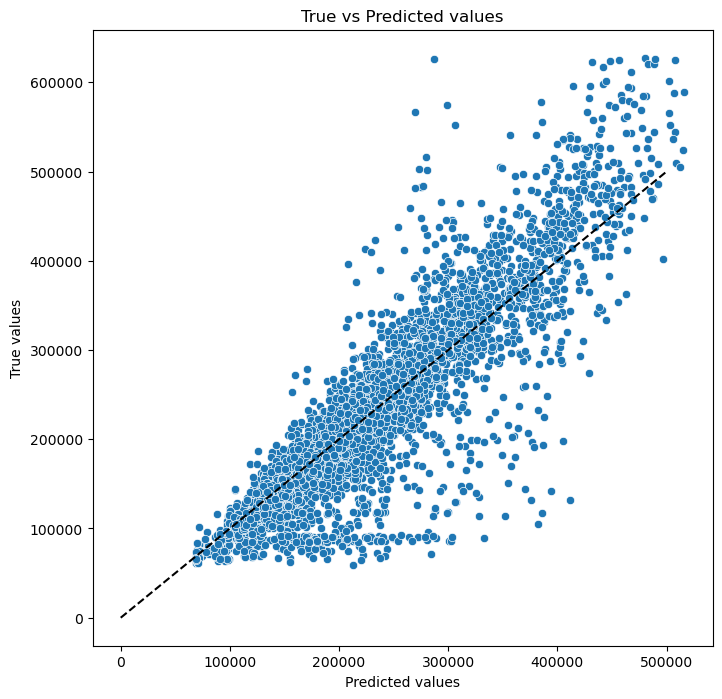

In [205]:
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=20, # глубина дерева  
                                 min_samples_leaf=10, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42,
                                 n_estimators=100  # кол-во деревьев
                                 )

rf_model.fit(X_train, y_train)
y_train_preds = rf_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.688
RMSE:	51854.793
MSE:	2688919588.538


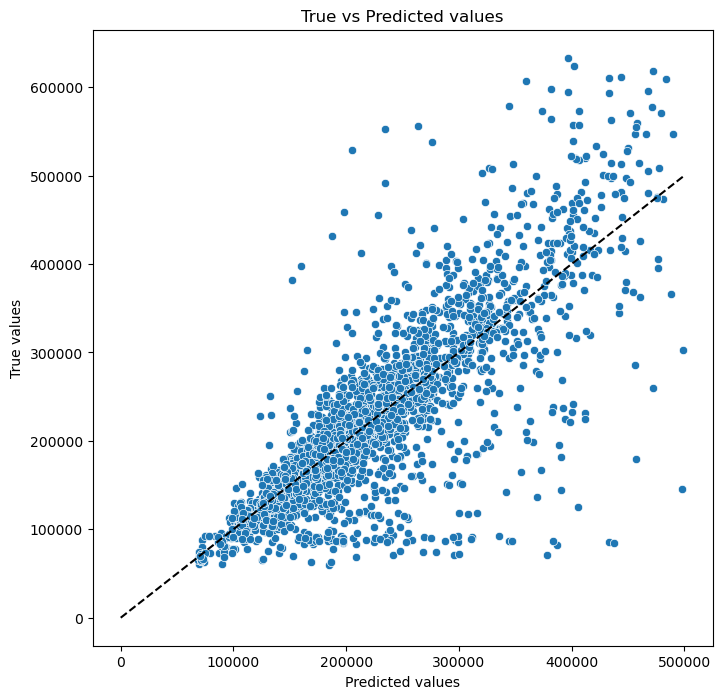

In [200]:
y_valid_preds = rf_model.predict(X_valid)
evaluate_preds(y_valid, y_valid_preds)

### Gradient Boosting decision trees

In [206]:
# gb_model = GradientBoostingRegressor(criterion='mse',
#                          min_samples_leaf=10,
#                          random_state=42,
#                          # n_estimators=100,
#                          # max_depth=7
#                          )

In [207]:
#%%time
#params = {'n_estimators':[50, 100, 200, 400], 
#           'max_depth':[3, 5, 7, 10]}

# gs = GridSearchCV(gb_model, params, 
#                   scoring='r2', # метрика 
#                   cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
#                            random_state=42, 
#                            shuffle=True),
#                   n_jobs=-1
#                   )
# gs.fit(X_train, y_train)

Wall time: 2min 16s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingRegressor(criterion='mse',
                                                 min_samples_leaf=10,
                                                 random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'n_estimators': [50, 100, 200, 400]},
             scoring='r2')

In [208]:
#gs.best_params_

{'max_depth': 5, 'n_estimators': 200}

С помощью GridSearchCV нашла оптимальные параметры для модели GradientBoostingRegressor {'max_depth': 5, 'n_estimators': 200}

R2:	0.866
RMSE:	33971.704
MSE:	1154076685.308


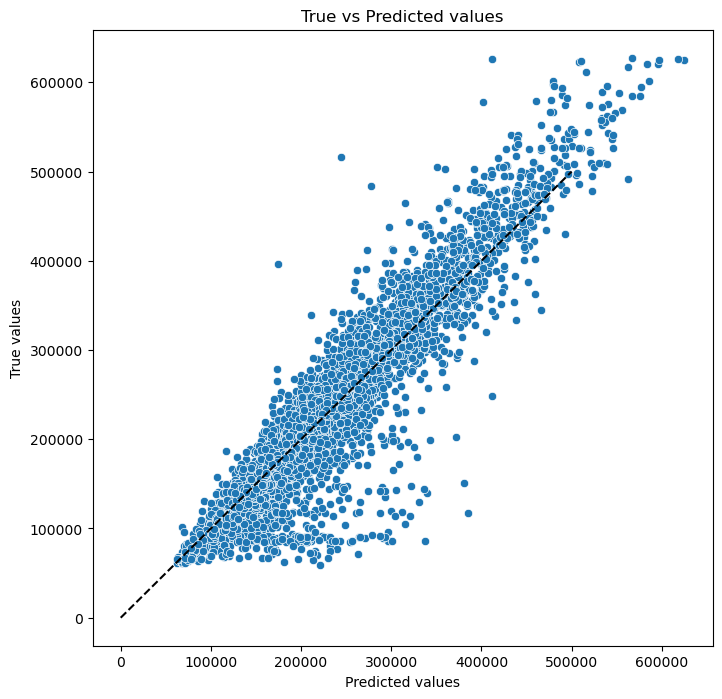

In [209]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=5,
                                     min_samples_leaf=10,
                                     random_state=42,  
                                     n_estimators=200)
gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.726
RMSE:	48579.859
MSE:	2360002674.706


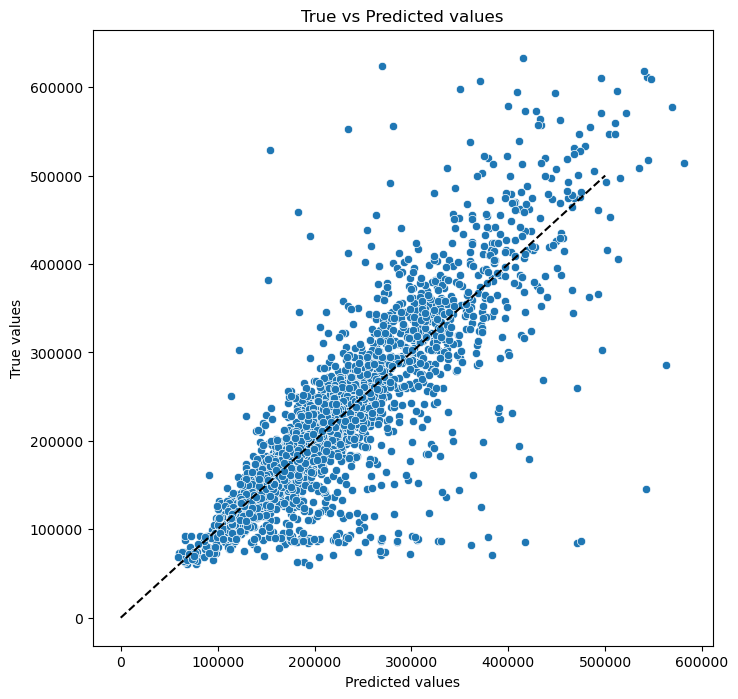

In [210]:
y_valid_preds = gb_model.predict(X_valid)
evaluate_preds(y_valid, y_valid_preds)

In [211]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(gb_model, file)

## Предсказание цен

In [219]:
X_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Id                5000 non-null   int64   
 1   DistrictId        5000 non-null   int64   
 2   Rooms             5000 non-null   float64 
 3   Square            5000 non-null   float64 
 4   LifeSquare        5000 non-null   float64 
 5   KitchenSquare     5000 non-null   float64 
 6   Floor             5000 non-null   int64   
 7   HouseFloor        5000 non-null   float64 
 8   HouseYear         5000 non-null   int64   
 9   Ecology_1         5000 non-null   float64 
 10  Ecology_2         5000 non-null   category
 11  Ecology_3         5000 non-null   category
 12  Social_1          5000 non-null   int64   
 13  Social_2          5000 non-null   int64   
 14  Social_3          5000 non-null   int64   
 15  Helthcare_2       5000 non-null   int64   
 16  Shops_1           5000 n

In [220]:
X_final.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Ecology_2_coding,Ecology_3_coding,Shops_2_coding
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,B,11,2748,1,0,0,B,1,1,1
1,15856,74,2.0,69.263183,32.925087,3.0,1,1.0,1977,0.075779,...,B,6,1437,3,0,2,B,1,1,1
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,...,B,30,7538,87,5,5,B,1,1,1
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,B,23,4583,3,3,3,B,1,1,1
4,14275,27,1.0,47.527111,43.387569,3.0,17,17.0,2017,0.072158,...,B,2,629,1,0,0,A,1,1,0


In [221]:
res = X_final[['Id']].copy()

In [222]:
X_final = X_final[feature_names]
y_pred_final = gb_model.predict(X_final)

In [223]:
y_pred_final

array([165816.89602466, 205799.19470166, 207166.16158767, ...,
       309724.30451118, 210272.68645659, 192234.76585323])

In [224]:
final = pd.concat([res, pd.DataFrame(y_pred_final, columns=['Price'])], axis=1)

In [225]:
final.head()

,Id,Price
0,725,165816.896025
1,15856,205799.194702
2,5480,207166.161588
3,15664,351455.216048
4,14275,143138.864080


In [226]:
final.to_csv('sample_submission.csv', sep=",", index=False)

На сайте kaggle.com результат 0.72711.